## Using Marbert Embeddings

In [1]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERT")
model = AutoModelForMaskedLM.from_pretrained("UBC-NLP/MARBERT")


pytorch_model.bin:  46%|####6     | 304M/654M [00:00<?, ?B/s]

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls

## Imports

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout
import random

np.random.seed(777)
tf.random.set_seed(777)
random.seed(777)

In [6]:
df = pd.read_csv('Data/App Reviews-SingleLabel-Multiclass.csv')

print(f"Dataset shape: {df.shape}")
print("\nSample data:")
print(df.head())

print("\nMissing values:")
print(df.isnull().sum())

print("\nBasic statistics:")
print(df.describe(include='all'))

Dataset shape: (2900, 2)

Sample data:
                                              review                Label
0                                 يبيله تصليحات كثير           bug_report
1                  ماتحملت ابدددددا ونا دفعت فلوس 🤔😕               rating
2  اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...  improvement_request
3      ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت               rating
4                                تبين م لي ي تم ل يب               others

Missing values:
review    0
Label     0
dtype: int64

Basic statistics:
                 review   Label
count              2900    2900
unique             2892       4
top     التطبيق لا يعمل  rating
freq                  3    1298


## Analysis

Label distribution:
Label
rating                 1298
bug_report              756
improvement_request     442
others                  404
Name: count, dtype: int64

Label percentages:
Label
rating                 44.76
bug_report             26.07
improvement_request    15.24
others                 13.93
Name: count, dtype: float64


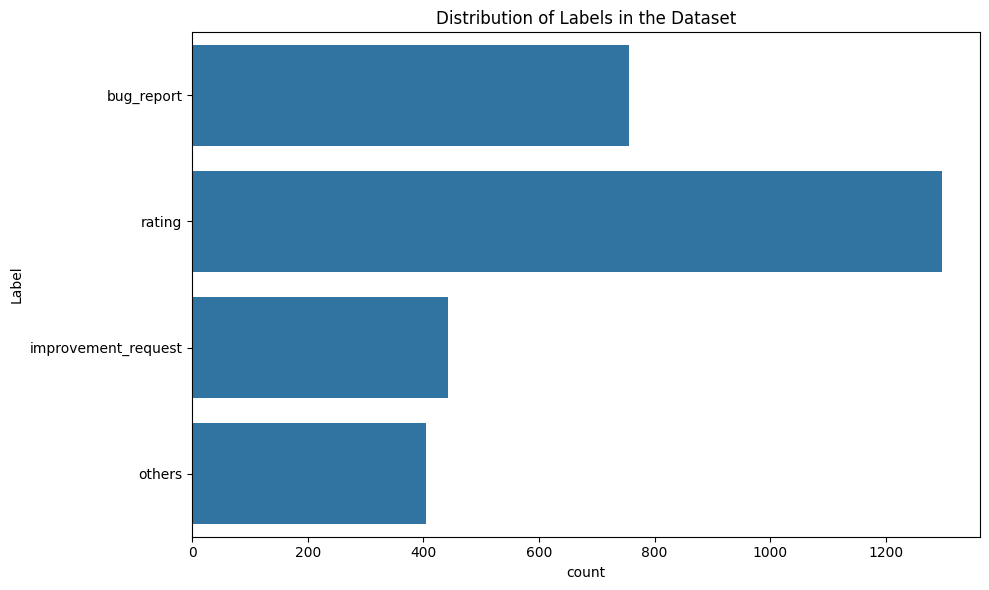

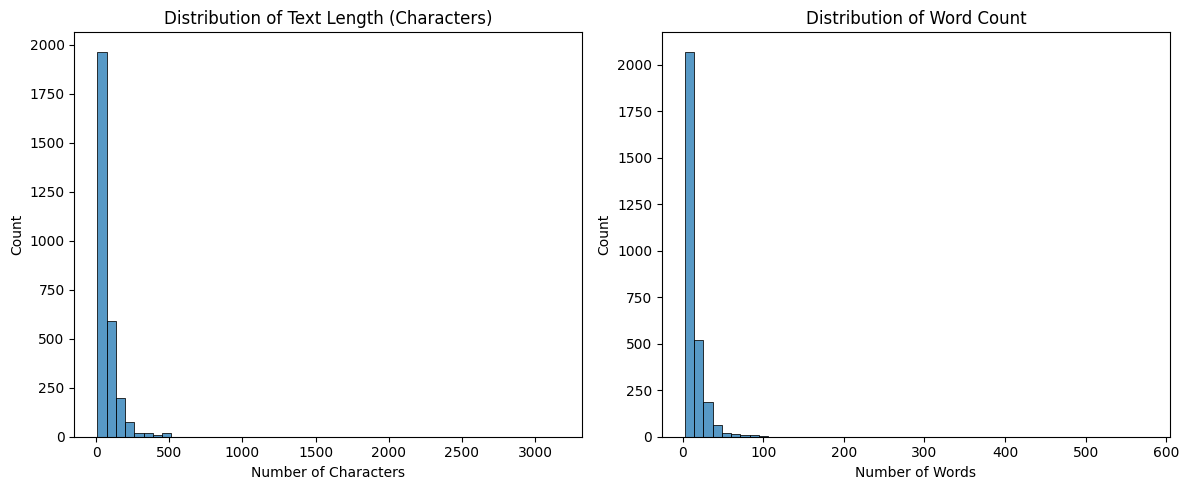


Text length statistics by label:
                      count       mean         std   min   25%   50%     75%  \
Label                                                                          
bug_report            756.0  81.029101   58.989946  13.0  41.0  65.0  102.00   
improvement_request   442.0  86.907240   81.802278  15.0  38.0  59.5  103.00   
others                404.0  86.940594  179.752632  11.0  29.0  44.0   82.25   
rating               1298.0  62.698767   55.206818  10.0  31.0  46.5   75.00   

                        max  
Label                        
bug_report            500.0  
improvement_request   498.0  
others               3166.0  
rating                499.0  

Word count statistics by label:
                      count       mean        std  min  25%   50%    75%  \
Label                                                                      
bug_report            756.0  15.055556  10.854466  3.0  8.0  12.0  19.00   
improvement_request   442.0  15.685520  14.9

In [7]:
label_counts = df['Label'].value_counts()
print("Label distribution:")
print(label_counts)
print("\nLabel percentages:")
print(round(label_counts / len(df) * 100, 2))

plt.figure(figsize=(10, 6))
sns.countplot(y='Label', data=df)
plt.title('Distribution of Labels in the Dataset')
plt.tight_layout()
plt.show()

df['text_length'] = df['review'].apply(len)
df['word_count'] = df['review'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['text_length'], bins=50)
plt.title('Distribution of Text Length (Characters)')
plt.xlabel('Number of Characters')

plt.subplot(1, 2, 2)
sns.histplot(df['word_count'], bins=50)
plt.title('Distribution of Word Count')
plt.xlabel('Number of Words')
plt.tight_layout()
plt.show()

print("\nText length statistics by label:")
print(df.groupby('Label')['text_length'].describe())

print("\nWord count statistics by label:")
print(df.groupby('Label')['word_count'].describe())

## Preprocessing


In [9]:
def preprocess_text(text):
    text = text.lower()
    
    text = re.sub(r'[^\w\s]', '', text)
    
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

df['processed_text'] = df['review'].apply(preprocess_text)

print("Original vs Processed Text Examples:")
for i in range(3):
    print(f"Original: {df['review'].iloc[i]}")
    print(f"Processed: {df['processed_text'].iloc[i]}")
    print()

Original vs Processed Text Examples:
Original: يبيله تصليحات كثير
Processed: يبيله تصليحات كثير

Original: ماتحملت ابدددددا ونا دفعت فلوس 🤔😕
Processed: ماتحملت ابدددددا ونا دفعت فلوس

Original: اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوضاً عن تفضيل الحلقات فقط
وشكراً
Processed: اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوضا عن تفضيل الحلقات فقط وشكرا



# Data split

In [10]:

label_mapping = {'bug_report': 0, 'improvement_request': 1, 'rating': 2, 'others': 3}
df['label_encoded'] = df['Label'].map(label_mapping)

X = df['processed_text'].values
y = df['label_encoded'].values

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=777, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15/0.8, random_state=777, stratify=y_train_val
)

print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

print("\nLabel distribution in train set:")
print(pd.Series(y_train).value_counts().sort_index())

print("\nLabel distribution in validation set:")
print(pd.Series(y_val).value_counts().sort_index())

print("\nLabel distribution in test set:")
print(pd.Series(y_test).value_counts().sort_index())

Train set size: 1885
Validation set size: 435
Test set size: 580

Label distribution in train set:
0    492
1    288
2    843
3    262
Name: count, dtype: int64

Label distribution in validation set:
0    113
1     66
2    195
3     61
Name: count, dtype: int64

Label distribution in test set:
0    151
1     88
2    260
3     81
Name: count, dtype: int64
